# Photo Caption Generator

Caption generation is a challenging artificial intelligence problem where a textual description must be generated for a given photograph.

It requires both methods from computer vision to understand the content of the image and a language model from the field of natural language processing to turn the understanding of the image into words in the right order. Recently, deep learning methods have achieved state-of-the-art results on examples of this problem.

Deep learning methods have demonstrated state-of-the-art results on caption generation problems. What is most impressive about these methods is a single end-to-end model can be defined to predict a caption, given a photo, instead of requiring sophisticated data preparation or a pipeline of specifically designed models.

### Steps:

* Photo and Caption Dataset
* Prepare Photo Data
* Prepare Text Data
* Build Deep Learning Model
* Train Model
* Evaluate Model
* Generate New Captions

The Flickr 8k dataset is used for image caption generation, which you can download by filling [this](https://forms.illinois.edu/sec/1713398) form provided by the University of Illinois at Urbana-Champaign. 

This dataset contains 8000 images each with 5 captions

This data split into three sets:
* Training Set — 6000 images
* Dev Set — 1000 images
* Test Set — 1000 images

Other Datasets,

* [COCO 2015 Image Captioning](http://cocodataset.org/#captions-2015)
* [Google Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/download)

In [0]:
# load packages
import numpy as np
from numpy import array

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
from PIL import Image
import glob
from pickle import dump, load
from nltk.translate.bleu_score import corpus_bleu

from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

### Read Dataset

In [0]:
project_path = "image_captioning/"

In [0]:
if os.path.isdir('Flickr8k_images') == False:
    os.mkdir('Flickr8k_images')
if os.path.isdir('Flickr8k_captions') == False:
    os.mkdir('Flickr8k_captions')

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'Flickr8k_Dataset.zip', 'r') as z:
    z.extractall("Flickr8k_images")

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'Flickr8k_text.zip', 'r') as z:
    z.extractall("Flickr8k_captions")

In [0]:
file_data = open("Flickr8k_captions/Flickr8k.token.txt",'r')
image_files = []
captions = []
for line in file_data.readlines():
    spl = line.split("#")
    image_files.append(spl[0])
    captions.append(str(spl[1]))

In [0]:
img_cap_dict = {"images":image_files,"captions":captions}

In [0]:
img_cap_df = pd.DataFrame(img_cap_dict,columns=img_cap_dict.keys())

In [13]:
img_cap_df.head()

,images,captions
0,1000268201_693b08cb0e.jpg,0\tA child in a pink dress is climbing up a se...
1,1000268201_693b08cb0e.jpg,1\tA girl going into a wooden building .\n
2,1000268201_693b08cb0e.jpg,2\tA little girl climbing into a wooden playho...
3,1000268201_693b08cb0e.jpg,3\tA little girl climbing the stairs to her pl...
4,1000268201_693b08cb0e.jpg,4\tA little girl in a pink dress going into a ...


### Preprocess Data

In [0]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
def clean_captions(caption):
    # tokenize
    caption = caption.split()
    # convert to lower case
    caption = [word.lower() for word in caption]
    # remove punctuation from each token
    caption = [w.translate(table) for w in caption]
    # remove hanging 's' and 'a'
    caption = [word for word in caption if len(word)>1]
    # remove tokens with numbers in them
    caption = [word for word in caption if word.isalpha()]
    # store as string
    return ' '.join(caption)

In [0]:
img_cap_df["captions"] = img_cap_df["captions"].apply(lambda x:clean_captions(x))

In [16]:
img_cap_df["captions"].values[:10]

array(['child in pink dress is climbing up set of stairs in an entry way',
       'girl going into wooden building',
       'little girl climbing into wooden playhouse',
       'little girl climbing the stairs to her playhouse',
       'little girl in pink dress going into wooden cabin',
       'black dog and spotted dog are fighting',
       'black dog and tricolored dog playing with each other on the road',
       'black dog and white dog with brown spots are staring at each other in the street',
       'two dogs of different breeds looking at each other on the road',
       'two dogs on pavement moving toward each other'], dtype=object)

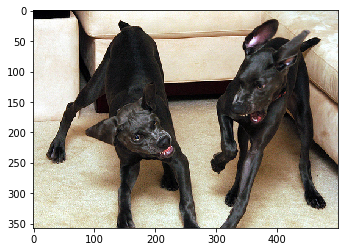

############## Image Description ###############

39180    two black dogs are bearing their teeth beside ...
39181     two black dogs are fighting in front of tan sofa
39182    two black dogs fight with each other with thei...
39183                two black dogs play or fight together
39184      two large black dogs are snarling at each other
Name: captions, dtype: object


In [17]:
img_file = img_cap_df["images"].values[np.random.randint(img_cap_df.shape[0])]
img_caption = img_cap_df["captions"][img_cap_df["images"] == img_file]

x=plt.imread("Flickr8k_images/Flicker8k_Dataset/"+img_file)
plt.imshow(x)
plt.show()
print("############## Image Description ###############\n")
print(img_caption)

In [18]:
img_cap_df.shape

(40460, 2)

### Prepare Photo Data

In [0]:
# Below path contains all the images
images = 'Flickr8k_images/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [0]:
# Below file conatains the names of images to be used in train data
train_images_file = "Flickr8k_captions/Flickr_8k.trainImages.txt"
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr8k_captions/Flickr_8k.testImages.txt'
# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [0]:
# load clean descriptions into memory
def load_train_descriptions(train_images):
    descriptions = dict()
    for filepath in train_images:
        # get filename
        filename = os.path.basename(filepath)
        img_captions = img_cap_df["captions"][img_cap_df["images"] == filename].values
        img_captions = ['START ' + cap + ' END' for cap in img_captions]
        descriptions[filename] = img_captions
    return descriptions

In [0]:
# Get train and test Descriptions
train_data = load_train_descriptions(train_img)
test_data = load_train_descriptions(test_img)

In [24]:
# Load the inception v3 model
InceptionV3_model = InceptionV3(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(InceptionV3_model.input, InceptionV3_model.layers[-2].output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
96116736/96112376 [==============================] - 8s 0us/step


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
# Encode all the train images
train_features = {}
for img in train_img:
    train_features[os.path.basename(img)] = encode(img)

In [0]:
# Encode all the test images
test_features = {}
for img in test_img:
    test_features[os.path.basename(img)] = encode(img)

### Prepare Description Data

In [0]:
# Create a list of all the captions
all_descriptions = ['START ' + des + ' END' for des in img_cap_df["captions"].values]

In [31]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_descriptions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 8765 -> 1949


In [0]:
# mapping words to integers and integers to words
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [33]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1950

In [34]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_data)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
if os.path.isdir('glove') == False:
    os.mkdir('glove')

glove_dir = "/content/drive/My Drive/DLCP/datasets/"
from zipfile import ZipFile
with ZipFile(glove_dir+'glove.zip', 'r') as z:
    z.extractall("glove")

In [36]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join("glove/", 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# Get Glove word embeddings
# ! wget -O glove http://nlp.stanford.edu/data/glove.6B.zip

In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [38]:
embedding_matrix.shape

(1950, 200)

In [0]:
# create training data
def create_data(max_length, descriptions, photos,wordtoix, vocab_size):
    X1, X2, y = list(), list(), list()
    for key, desc_list in descriptions.items():
        # retrieve the photo feature
        photo = photos[key]
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photo)
                X2.append(in_seq)
                y.append(out_seq)
    return [array(X1), array(X2)], array(y)

### Build Model

![image_cap.png](image_cap.png)

In [0]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [41]:
# define the model
model = define_model(vocab_size, max_length)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# set Glove vectors to embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [43]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam')
# summarize model
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      390000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
# plot_model(model, to_file='model.png', show_shapes=True)

In [0]:
# Get traning and validation data
Xtrain,ytrain = create_data(max_length, train_data, train_features,wordtoix, vocab_size)
Xtest,ytest = create_data(max_length, test_data, test_features,wordtoix, vocab_size)

In [0]:
# Defining a helper function to save the model after each epoch 
# in which the loss decreases 
filepath = project_path+'model_img_cap_vec.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time 
# the learning plateaus 
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, 
							patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint, es, reduce_alpha] 

### Train Model

In [53]:
# fit model
model.fit(Xtrain, ytrain, epochs=20, callbacks=callbacks,validation_data=(Xtest, ytest), verbose=1)

Train on 294532 samples, validate on 49348 samples
Epoch 1/20
294528/294532 [============================>.] - ETA: 0s - loss: 3.5798
Epoch 00001: val_loss improved from inf to 3.47667, saving model to /content/drive/My Drive/DLCP/openwork/image_captioning/model_img_cap_vec.h5
294532/294532 [==============================] - 1040s 4ms/sample - loss: 3.5798 - val_loss: 3.4767
Epoch 2/20
294528/294532 [============================>.] - ETA: 0s - loss: 3.3454
Epoch 00002: val_loss improved from 3.47667 to 3.42686, saving model to /content/drive/My Drive/DLCP/openwork/image_captioning/model_img_cap_vec.h5
294532/294532 [==============================] - 1053s 4ms/sample - loss: 3.3455 - val_loss: 3.4269
Epoch 3/20
294528/294532 [============================>.] - ETA: 0s - loss: 3.2545
Epoch 00003: val_loss did not improve from 3.42686
294532/294532 [==============================] - 1078s 4ms/sample - loss: 3.2545 - val_loss: 3.4293
Epoch 4/20
294528/294532 [============================>.]

### Evaluate Model

In [0]:
# generate a description for an image
def generate_desc(model, wordtoix, photo, max_length):
    # seed the generation process
    in_text = 'START'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # encode the sequence
        sequence = [wordtoix[word] for word in in_text.split(' ') if word in wordtoix]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([np.expand_dims(photo, axis=0),sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'END':
            break
    return in_text

In [0]:
# evaluate the skill of the model
def evaluate_model(model,wordtoix, descriptions, photos, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, wordtoix, np.asarray(photos[key]), max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [163]:
evaluate_model(model,wordtoix,test_data,test_features,max_length)

BLEU-1: 0.500600
BLEU-2: 0.276307
BLEU-3: 0.194860
BLEU-4: 0.093736


### Generate New Captions

In [0]:
def greedySearch(photo):
    in_text = 'START'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'END':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

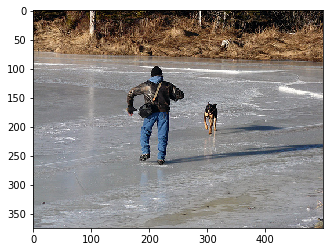

Greedy: man in red shirt and black wetsuit is surfing on the beach


In [56]:
pic = list(test_features.keys())[np.random.randint(len(test_features))]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

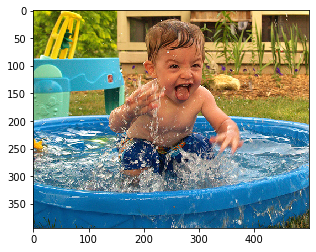

Greedy: little girl in blue shirt is running in the grass


In [58]:
pic = list(test_features.keys())[np.random.randint(len(test_features))]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

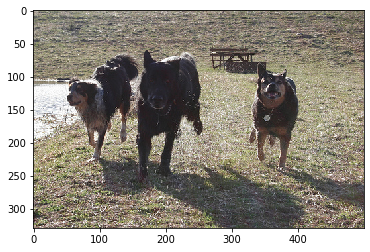

Greedy: black dog is running through the grass


In [59]:
pic = list(test_features.keys())[np.random.randint(len(test_features))]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))